# Barrio Tortuga Super mercado

- BTSP is a toy model to investigate the contacts in a Supermarket. 

In [270]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())
import numpy as np
import pandas as pd
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last updated on  Tue Apr 21 19:15:32 2020


In [271]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [272]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.visualization.TextVisualization import TextVisualization, TextGrid

In [273]:
from termcolor import colored

In [274]:
from enum import Enum
class PrtLvl(Enum):
    Mute     = 1
    Concise  = 2
    Detailed = 3
    Verbose  = 4

# Definition of Barrio Tortuga SMKT

### Tortuga SMKT

- Tortuga SMKT is modelled as an idealisation of a supermarket characterised by:

- Max people in SMKT: 120 (can be regulated)
- Area: 1600 m2.

**Barrio Tortuga SMKT**

- Non Toroidal grid of 40 x 4s0 m2
- grey patches represent walls: turtles cannot walk there.
- blue patches represent courridors for turtles to walk.
- red patches are hot spots (bounlagerie, fish, meat...). A turtle which has a hot spot patch as a neighbour has a probability ph to stay put in a given tick.
- green patches are payment spots. A turtle reaching there stays for a while (pp, larger than ph) then goes around through the blue patches to exit.

## Map for Barrio Tortuga

In [350]:
map_bt = np.genfromtxt("barrio-tortuga-smkt.txt")

In [347]:
map_bt.shape

(40, 40)

In [336]:
def is_courridor(map_bt, x, y):
    if map_bt[x,y] == 2:
        return True
    else:
        return False

def is_wall(map_bt, x, y):
    if map_bt[x,y] == 1:
        return True
    else:
        return False

def is_hot_spot(map_bt, x, y):
    if map_bt[x,y] == 3:
        return True
    else:
        return False

def is_payment(map_bt, x, y):
    if map_bt[x,y] == 4:
        return True
    else:
        return False

In [337]:
def print_smkt(map_bt, l=100, w=100, slw=True):
    if slw:
        l,w = map_bt.shape
    H=''
    for x in range(l):
        H+='\n'
        for y in range(w):
            if is_wall(map_bt, x, y):
                H += colored('x','grey')  # walls
            elif is_courridor(map_bt, x, y):
                H +=colored('x','blue')  # courridors
            elif is_hot_spot(map_bt, x, y):
                H +=colored('x','red')  # hot spots
            elif is_payment(map_bt, x, y):
                H +=colored('x','green') # cashier
            else:
                print(f'What???should not be here')
    H+='\n'
    return H
       

In [351]:
H = print_smkt(map_bt)

In [352]:
print(H)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxx

In [448]:
2**10

1024

# A simple model of walking in the SMKT.

- Turtles are placed at random in the blue patches (courridors), reflecting an arbitary snapshot in the supermarket flow. 
- Turtles have the same social affinity parameter defined to walk through the barrio. Depending on its value they may try to avoid the other turhtle, if possible.  

# Barrio Tortuga SMKT

In [396]:
"""
Definition of Tortuga Supermarket

#Tortuga SMKT is modelled as an idealisation of a supermarket characterised by:

- Max people in SMKT: 120 (can be regulated)
- Area: 1600 m2.

**Barrio Tortuga SMKT**

- Non Toroidal grid of 40 x 4s0 m2
- grey patches represent walls: turtles cannot walk there.
- blue patches represent courridors for turtles to walk.
- red patches are hot spots (bounlagerie, fish, meat...).
A turtle which has a hot spot patch as a neighbour has a probability ph to stay put in a given tick.
- green patches are payment spots. A turtle reaching there stays for a while
 (pp, larger than ph) then goes around through the blue patches to exit.
"""

from mesa import Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa import Agent
from mesa.time import RandomActivation
import numpy as np

from enum import Enum
class PrtLvl(Enum):
    Mute     = 1
    Concise  = 2
    Detailed = 3
    Verbose  = 4


def print_level(prtl, PRT):
    if prtl.value >= PRT.value:
        return True
    else:
        return False


prtl =PrtLvl.Verbose


def is_courridor(map_bt, x, y):
    if map_bt[x,y] == 2:
        return True
    else:
        return False

def is_wall(map_bt, x, y):
    if map_bt[x,y] == 1:
        return True
    else:
        return False

def is_hot_spot(map_bt, x, y):
    if map_bt[x,y] == 3:
        return True
    else:
        return False

def is_payment(map_bt, x, y):
    if map_bt[x,y] == 4:
        return True
    else:
        return False

def throw_dice(dice):
    atry =  np.random.random_sample() 
    if atry < dice:
        return True
    else:
        return False

def turtles_in_cell(cell):
    turtles = [obj for obj in cell if isinstance(obj, TurtleSmkt)]
    if len(turtles) > 0:
        return True
    else:
        return False

### AGENTS

class PatchSmkt(Agent):
    """
    A supermarket patch.
    kind = 1 means the patch belongs to a wall
    kind = 2 means the patch belongs to courridor
    kind = 3 means the patch belongs to a hot spot
    kind = 4 means the patch belongs to payment booth
    """
    def __init__(self, unique_id, pos, model, kind, moore=False):
        super().__init__(unique_id, model)
        self.kind   = kind
        self.pos    = pos
        self.moore  = moore
        

    def step(self):
        pass


class TurtleSmkt(Agent):
    '''
    A turtle able to move in a Supermarket
    '''
    def __init__(self, unique_id, pos, model, moore=True):
        super().__init__(unique_id, model)
        self.pos   = pos
        self.ppos   = None 
        self.moore = moore
               

    def move(self):
        """Turtles examine first if there is a hot spot or a payment booth nearby.
        If this is the case, they will wait with a probability given by model.pwait.
        Otherwise they seek for a free spot (with not turtles) and move.
        #TODO: free spot must be in the forward direction!
        """
        # Get neighborhood position and contents
        pos_neighbors = [i for i in self.model.grid.get_neighborhood(self.pos, self.moore, False)]
        
        if print_level(prtl, PrtLvl.Verbose):
            print(f'Before Turtle moves:  pos = {self.pos} ppos ={self.ppos}')
            print(f'Position neighbors = {pos_neighbors}')
               
        # if any neighboor is a hot spot or a payment booth throw a dice and wait if True
        wait = False
        hot_spots     = np.array([is_hot_spot(map_bt, *pos) for pos in pos_neighbors])
        
        if print_level(prtl, PrtLvl.Verbose):
            print(f'Hot spots = {hot_spots}')
        
        if hot_spots.any():
            if throw_dice(self.model.pwait_hotspot): 
                wait = True 
                
        if print_level(prtl, PrtLvl.Verbose):
            print(f'Wait in hot spot = {wait}')

        payment_spots = np.array([is_payment(map_bt, *pos) for pos in pos_neighbors])
        
        if print_level(prtl, PrtLvl.Verbose):
            print(f'payment_spots = {payment_spots}')
            print(f'Wait in payment? = {wait}')
        
        if payment_spots.any():
            if throw_dice(self.model.pwait_payment): 
                wait = True 

        if wait == False:  
            # allowed neighbors are courridor patches
            allowed_neighbors       = np.array([pos for pos in pos_neighbors if is_courridor(map_bt, *pos)])
            
            if print_level(prtl, PrtLvl.Verbose):
                print(f'allowed_neighbors = {allowed_neighbors}')
            # cell contents (cc) in allowed neighbors
            cc_in_allowed_neighbors = [self.model.grid.get_cell_list_contents([pos]) for pos in allowed_neighbors]
            
            if print_level(prtl, PrtLvl.Verbose):
                print(f'cc_in_allowed_neighbors = {cc_in_allowed_neighbors}')
            
            # True if no turtles found in cell
            not_filled_with_turtles = np.array([turtles_in_cell(cc) == False for cc in cc_in_allowed_neighbors])
            
            if print_level(prtl, PrtLvl.Verbose):
                print(f'not_filled_with_turtles = {not_filled_with_turtles}')
            
            # select neighbors as those patches not filled with turtles
            selected_neighbors = allowed_neighbors[not_filled_with_turtles]
            
            if print_level(prtl, PrtLvl.Verbose):
                print(f'selected_neighbors before reshufling = {selected_neighbors}')
                        
            # it not available spots without turtles move to any courridor patch
            if len(selected_neighbors) == 0:  
                selected_neighbors = allowed_neighbors 
                
            if self.ppos = None:  #first time here. select random
                self.ppos  = self.pos
            
                pos = self.select_random_spot(selected_neighbors)
            
                if print_level(prtl, PrtLvl.Verbose):
                    print(f'Firs time in step: select at random pos = {pos}')
                
                self.model.grid.move_agent(self, pos)
            else:
                # compute direction
                # keep direction until you hit a wall or reach a hot spot
            
            if print_level(prtl, PrtLvl.Verbose):
                print(f'After Turtle moves:  pos = {self.pos} ppos ={self.ppos}')
                
    def select_random_spot(self, neighbors):
        selected = []
        for sn in neighbors:
            selected.append((sn[0], sn[1]))
        self.random.shuffle(selected)
        return selected[0]
  

    def step(self):
        self.move()

# MODEL
def number_of_encounters(model):
    nc = 0
    for y in range(model.grid.height):
        for x in range(model.grid.width):
            this_cell = model.grid.get_cell_list_contents((x,y))
            n_turtles = len([obj for obj in this_cell if isinstance(obj, TurtleSmkt)])
            if n_turtles > 0:
                if print_level(prtl, PrtLvl.Verbose):
                    print(f'number of turtles found in {x,y} -->{ n_turtles}')
            if n_turtles > 1:
                nc += 1

    if print_level(prtl, PrtLvl.Detailed):
        print(f'total number of encounters this step ={nc}')
    return nc

def number_of_turtles_in_neighborhood(model):
    for y in range(model.grid.height):
        for x in range(model.grid.width):
            c = model.grid.get_cell_list_contents((x,y))
            if len(c) > 0:
                n_xy = model.grid.get_neighborhood((x,y), model.moore, False) #coordinates of neighbors
                nc = 0
                for xy in n_xy:
                    c = model.grid.get_cell_list_contents((xy[0], xy[1]))
                    nc += len(c)

    return nc

class TortugaSmkt(Model):
    '''
    A model of a supermarket, where turtles go and shop.

    '''

    def __init__(self,
                 map_file="barrio-tortuga-smkt.txt",
                 turtles=50,
                 wait_hotspot = 0.5,
                 wait_payment = 0.7,
                 prtl=PrtLvl.Concise):
        '''
        Create a new Tortuga supermarket.

        The supermarket is created from a map. It is a toroidal object. The supermarket
        The barrio is filled with turtles that are placed in any available spot in courridors at random
        and can exist the buildings through a set of doors.
        There are many doors in the building. This is meant to represent the temporal spread in
        the turtles coming in and out of the buildings.

        In a real building persons go out by the same
        door at different times. In Barrio Tortugas, turtles go out of the buildings through a set
        of doors. Each turtle chooses a door to go out at random. This is equivalent to introduce
        randomness on the exit time.

        Args:
            The  name file with the barrio map
            number of turtles in the barrio
            social_affinity a parameter that sets the social affinity of turtles. It takes
            values between -1 and 1. For positive values (0, 1), turtles seek contact with
            other turtles. For negative values (-1, 0), turtles avoid contact with others.
            A value of social_affinity of 1 means that a turtle that finds another turhtle nearby
            always moves to its cell. A social affinity of -1 means that a turtle always tries
            to avoid any turtle nearby.
            nd, a parameter that decides the number of doors (largest for nd=1)
        '''

        # read the map
        self.map_bt                 = np.genfromtxt(map_file)
        self.wait_hotspot           = wait_hotspot
        self.wait_payment           = wait_payment

        if print_level(prtl, PrtLvl.Concise):
            print(f'loaded tortuga supermarket with dimensions ->{ self.map_bt.shape}')
            print(f'wait hotspot ->{self.wait_hotspot}')
            print(f'wait payment ->{self.wait_payment}')


        self.height, self.width     = self.map_bt.shape
        self.grid                   = MultiGrid(self.height, self.width, torus=True)
        self.moore                  = True
        self.turtles                = turtles
        self.schedule               = RandomActivation(self)
        self.datacollector          = DataCollector(
        model_reporters             = {"NumberOfEncounters": number_of_encounters}
        )

        # create the patches representing houses and avenues
        id = 0
        for _, x, y in self.grid.coord_iter():
            patch_kind = self.map_bt[x, y]               # patch kind labels buildings or streets
            patch      = PatchSmkt(id, (x, y), self, patch_kind)
            self.grid.place_agent(patch, (x, y))         # agents are placed in the grid but not in the
                                                         # in the schedule

        # Create turtles distributed randomly in the spmkt
 
        for i in range(int(self.turtles)):
            x,y = self.random_pos()
            while is_courridor(self.map_bt, x, y) == False :
                x,y = self.random_pos()
            
            if print_level(prtl, PrtLvl.Detailed):
                print(f'starting turtle {i} at  x,y ={x,y}')

            a = TurtleSmkt(i, (x, y), self, True)  # create Turtle
            self.schedule.add(a)               # add to scheduler
            self.grid.place_agent(a, (x, y))   # place Turtle in the grid
        
        self.running = True

        # activate data collector
        self.datacollector.collect(self)

    def random_pos(self):
        x = self.random.randrange(self.width)
        y = self.random.randrange(self.height)
        return x, y
        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

In [397]:
def run_turtles(turtles, steps, wait_hotspot = 0.5, wait_payment = 0.7, map_file="barrio-tortuga-smkt.txt", 
                prtl=PrtLvl.Concise, prtf = 100):
    """Run turtles in Tortuga supermarket"""
    
    print(f" Running Tortuga supermarket with {turtles}  turtles, for {steps} steps.")
    bt = TortugaSmkt(map_file=map_file, turtles=turtles, wait_hotspot = 0.5, wait_payment = 0.7, prtl=prtl)
    
    for i in range(steps):
        if i%prtf == 0:
            print(f' step {i}')
        bt.step()
    print('Done!')
    return bt.datacollector.get_model_vars_dataframe()

In [398]:
run_turtles(turtles=2, steps=10, wait_hotspot = 0.5, wait_payment = 0.7, map_file="barrio-tortuga-smkt.txt", 
                prtl=PrtLvl.Verbose, prtf = 1)

 Running Tortuga supermarket with 2  turtles, for 10 steps.
loaded tortuga supermarket with dimensions ->(40, 40)
wait hotspot ->0.5
wait payment ->0.7
starting turtle 0 at  x,y =(9, 22)
starting turtle 1 at  x,y =(24, 19)
number of turtles found in (24, 19) -->1
number of turtles found in (9, 22) -->1
total number of encounters this step =0
 step 0
Before Turtle moves:  pos = (9, 22) ppos =None
Position neighbors = [[ 8 21]
 [ 9 21]
 [10 21]
 [ 8 22]
 [10 22]
 [ 8 23]
 [ 9 23]
 [10 23]]
Hot spots = [False False False False False False False False]
Wait in hot spot = False
payment_spots = [False False False False False False False False]
Wait in payment? = False
allowed_neighbors = [[ 8 21]
 [ 9 21]
 [10 21]
 [ 8 22]
 [10 22]
 [ 8 23]
 [ 9 23]
 [10 23]]
cc_in_allowed_neighbors = [[<__main__.PatchSmkt object at 0x119b92b90>], [<__main__.PatchSmkt object at 0x119b9d5d0>], [<__main__.PatchSmkt object at 0x119b9dfd0>], [<__main__.PatchSmkt object at 0x119b92bd0>], [<__main__.PatchSmkt obje

,NumberOfEncounters
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## First. No social distancing. Assume that all turtles go out at the same time, with large social affinity (0.8) 

In [239]:
dft = run_turtles(turtles=220, social_affinity = 0.8, steps=500, nd=2)

 Running Barrio Tortuga with 220  turtles, for 500 steps.
loaded barrio tortuga map with dimensions ->(100, 100)
social affinity ->0.8
number of doors = 804
 step 0
 step 100
 step 200
 step 300
 step 400
Done!


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116591050>]],
      dtype=object)

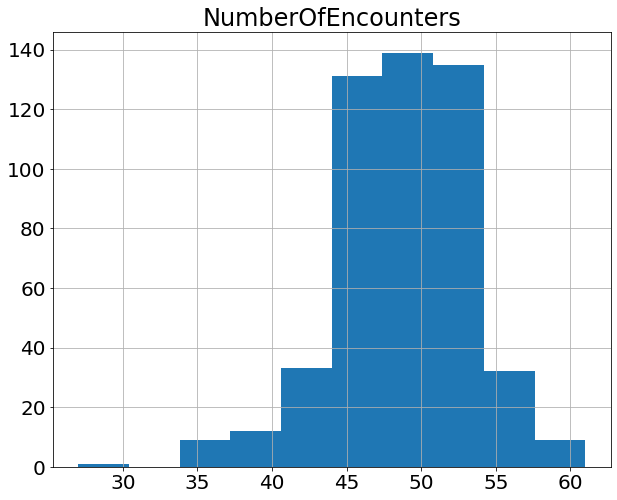

In [240]:
dft.hist("NumberOfEncounters")

In [241]:
dft.sum() /500

NumberOfEncounters    48.732
dtype: float64

In [242]:
dft.mean()

NumberOfEncounters    48.634731
dtype: float64

In [243]:
dft.std()

NumberOfEncounters    4.596554
dtype: float64

## Social distancing (I). Still all turtles go out, but not social_affinity=9

In [244]:
dft = run_turtles(turtles=220, social_affinity = 0.0, steps=500, nd=2)

 Running Barrio Tortuga with 220  turtles, for 500 steps.
loaded barrio tortuga map with dimensions ->(100, 100)
social affinity ->0.0
number of doors = 804
 step 0
 step 100
 step 200
 step 300
 step 400
Done!


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119e6e290>]],
      dtype=object)

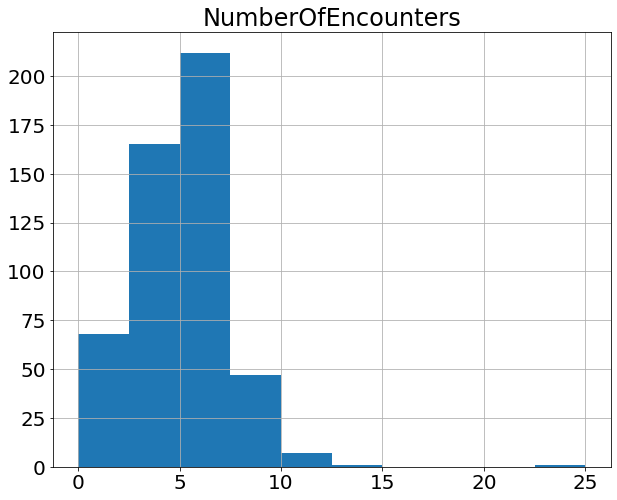

In [245]:
dft.hist("NumberOfEncounters")

In [246]:
dft.mean()

NumberOfEncounters    4.838323
dtype: float64

In [247]:
dft.std()

NumberOfEncounters    2.337479
dtype: float64

## Social distancing (II). Still all turtles go out, but they try to avoid each other: social_affinity = -0.8

In [249]:
dft = run_turtles(turtles=220, social_affinity = -0.8, steps=500, nd=2)

 Running Barrio Tortuga with 220  turtles, for 500 steps.
loaded barrio tortuga map with dimensions ->(100, 100)
avoid awareness ->0.8
number of doors = 804
 step 0
 step 100
 step 200
 step 300
 step 400
Done!


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1192d4510>]],
      dtype=object)

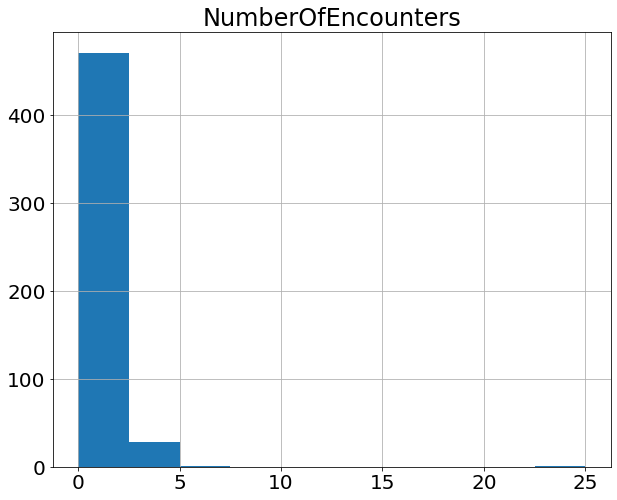

In [250]:
dft.hist("NumberOfEncounters")

In [251]:
dft.mean()

NumberOfEncounters    0.942116
dtype: float64

In [252]:
dft.std()

NumberOfEncounters    1.426409
dtype: float64

## Social distancing (III). A large part of the population stay home. Only a fraction go out for a walk or spot. F = 30%. Social_affinity = -0.8

In [256]:
dft = run_turtles(turtles=220 * 0.3, social_affinity = -0.8, steps=500, nd=2)

 Running Barrio Tortuga with 66.0  turtles, for 500 steps.
loaded barrio tortuga map with dimensions ->(100, 100)
avoid awareness ->0.8
number of doors = 804
 step 0
 step 100
 step 200
 step 300
 step 400
Done!


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1165a5490>]],
      dtype=object)

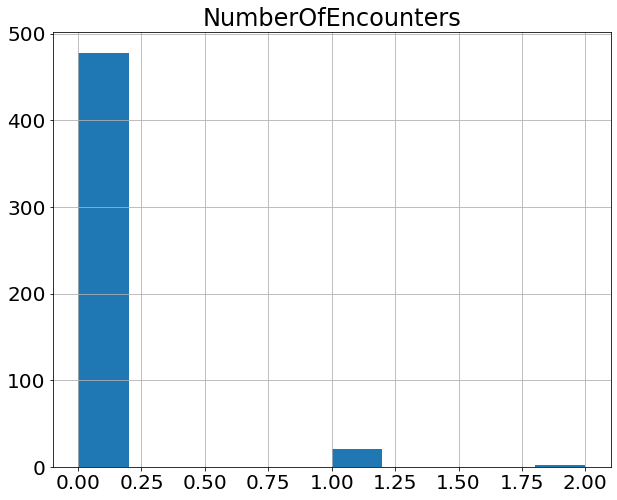

In [257]:
dft.hist("NumberOfEncounters")

In [258]:
dft.mean()

NumberOfEncounters    0.0499
dtype: float64

In [259]:
dft = run_turtles(turtles=220 * 0.1, social_affinity = -0.8, steps=500, nd=2)

 Running Barrio Tortuga with 22.0  turtles, for 500 steps.
loaded barrio tortuga map with dimensions ->(100, 100)
avoid awareness ->0.8
number of doors = 804
 step 0
 step 100
 step 200
 step 300
 step 400
Done!


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11955e450>]],
      dtype=object)

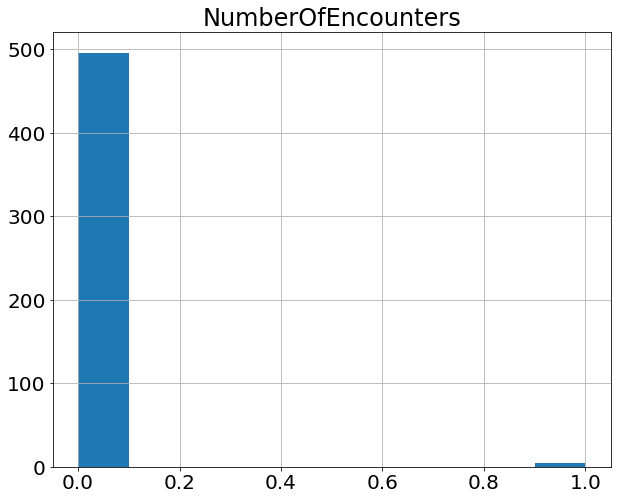

In [260]:
dft.hist("NumberOfEncounters")

In [261]:
dft.mean()

NumberOfEncounters    0.00998
dtype: float64

In [262]:
220 * 0.3

66.0

In [264]:
350E+3 /(30 * 1.4e+3)

8.333333333333334